# Quantify strand exchange

This notebook examines strand exchange that might happen during PCR or SMRTbell library preparation. We do so by looking at mixin of wildtype and synonymous viral tags in pacbio CCSs. 

In [1]:
from alignparse.constants import CBPALETTE

import numpy as np

import pandas as pd

import plotnine as p9

import yaml

Import snakemake variables.

In [2]:
viral_tags = snakemake.input.viral_tags
mutation_df = snakemake.input.mutation_df
plot_strand_exchange = snakemake.output.plot_strand_exchange
mutation_and_tag_identity_df = snakemake.output.mutation_and_tag_identity_df

# viral_tags = '../data/flu_sequences/flu-CA09_viral_tags.yaml'
# mutation_df = '../results/pacbio/hashing_highMOI_mutations_by_ccs.csv.gz'

Here we load viral tag yalm and alignment files.

In [3]:
with open(viral_tags) as file:
    tags = yaml.load(file, Loader=yaml.FullLoader)

Now we load ccs alignment dataframe with information about tag identities

In [4]:
alignments = pd.read_csv(mutation_df, compression='gzip', low_memory=False)

Here we only select columns with information about the ccs, gene, transcript and tag variant identities.

In [5]:
filter_col_sequence = [col for col in alignments
                       if col.startswith('variant_tag')
                       and col.endswith('_sequence')]

df1 = alignments[['query_name', 'gene', 'transcript']]
df2 = alignments[filter_col_sequence]
alignments_tags = pd.concat([df1, df2], axis=1, sort=False)

alignments_tags.head()

,query_name,gene,transcript,variant_tag_1_sequence,variant_tag_2_sequence,variant_tag_3_sequence,variant_tag_4_sequence,variant_tag_5_sequence,variant_tag_6_sequence,variant_tag_7_sequence,variant_tag_8_sequence
0,m54228_201020_194205/4194462/ccs,fluHA,fluHA,T,C,NaN,NaN,NaN,NaN,NaN,NaN
1,m54228_201020_194205/4194571/ccs,fluHA,fluHA,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,m54228_201020_194205/4194630/ccs,fluHA,fluHA,T,T,NaN,NaN,NaN,NaN,NaN,NaN
3,m54228_201020_194205/4194734/ccs,fluHA,fluHA,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,m54228_201020_194205/4194868/ccs,fluHA,fluHA,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Now we will melt our alignment dataframe.

In [6]:
alignments_melt = pd.melt(alignments_tags,
                          id_vars=['query_name', 'gene', 'transcript'],
                          value_vars=filter_col_sequence,
                          var_name='tag_number',
                          value_name='tag_identity')

alignments_melt.head()

,query_name,gene,transcript,tag_number,tag_identity
0,m54228_201020_194205/4194462/ccs,fluHA,fluHA,variant_tag_1_sequence,T
1,m54228_201020_194205/4194571/ccs,fluHA,fluHA,variant_tag_1_sequence,C
2,m54228_201020_194205/4194630/ccs,fluHA,fluHA,variant_tag_1_sequence,T
3,m54228_201020_194205/4194734/ccs,fluHA,fluHA,variant_tag_1_sequence,T
4,m54228_201020_194205/4194868/ccs,fluHA,fluHA,variant_tag_1_sequence,T


Here we have to rename `variant` to `viral` and remove `_sequence` the end of `tag_number` column becasue the tag yalm file has different naming. 

In [7]:
alignments_melt['tag_number'] = (alignments_melt['tag_number']
                                 .map(lambda x: x.replace('_sequence', '')))
alignments_melt['tag_number'] = (alignments_melt['tag_number']
                                 .str.replace('variant', "viral"))
alignments_melt.head()

,query_name,gene,transcript,tag_number,tag_identity
0,m54228_201020_194205/4194462/ccs,fluHA,fluHA,viral_tag_1,T
1,m54228_201020_194205/4194571/ccs,fluHA,fluHA,viral_tag_1,C
2,m54228_201020_194205/4194630/ccs,fluHA,fluHA,viral_tag_1,T
3,m54228_201020_194205/4194734/ccs,fluHA,fluHA,viral_tag_1,T
4,m54228_201020_194205/4194868/ccs,fluHA,fluHA,viral_tag_1,T


Now convert tag dictionary into pandas df.

In [8]:
tag_df = pd.DataFrame.from_dict({(i, j): tags[i][j]
                                 for i in tags.keys()
                                 for j in tags[i].keys()},
                                orient='index')
tag_df.reset_index(inplace=True)
tag_df = tag_df.rename(columns={'level_0': 'gene', 'level_1': 'tag_number'})
tag_df.head()

,gene,tag_number,syn,wt
0,fluHA,viral_tag_1,T,C
1,fluHA,viral_tag_2,C,T
2,fluM,viral_tag_1,A,G
3,fluM,viral_tag_2,G,A
4,fluNA,viral_tag_1,A,G


We can now merge tag and alignment files by `gene` and `tag_number` columns.

In [9]:
tags_merged = pd.merge(alignments_melt, tag_df,
                       how='right', left_on=['gene', 'tag_number'],
                       right_on=['gene', 'tag_number'])
tags_merged.head()

,query_name,gene,transcript,tag_number,tag_identity,syn,wt
0,m54228_201020_194205/4194462/ccs,fluHA,fluHA,viral_tag_1,T,T,C
1,m54228_201020_194205/4194571/ccs,fluHA,fluHA,viral_tag_1,C,T,C
2,m54228_201020_194205/4194630/ccs,fluHA,fluHA,viral_tag_1,T,T,C
3,m54228_201020_194205/4194734/ccs,fluHA,fluHA,viral_tag_1,T,T,C
4,m54228_201020_194205/4194868/ccs,fluHA,fluHA,viral_tag_1,T,T,C


After merging cells with `NaN` in `tag_identity` indicate missing tags in CCSs, I'm going to rename those as `missing`

In [10]:
tags_merged['tag_identity'] = (tags_merged['tag_identity']
                               .fillna(value='missing'))

In [11]:
# create a list of our conditions
conditions = [
    (tags_merged['tag_identity'] == tags_merged['syn']),
    (tags_merged['tag_identity'] == tags_merged['wt']),
    (tags_merged['tag_identity'] == 'missing'),
    ((tags_merged['tag_identity'] != tags_merged['syn'])
     & (tags_merged['tag_identity'] != tags_merged['wt']))
    ]

# create a list of the values we want to assign for each condition
values = ['syn', 'wt', 'missing', 'unknown tag']

# create a new column and use np.select to assign values to it
tags_merged['tag_variant'] = np.select(conditions, values)

# display updated DataFrame
tags_merged.head()

,query_name,gene,transcript,tag_number,tag_identity,syn,wt,tag_variant
0,m54228_201020_194205/4194462/ccs,fluHA,fluHA,viral_tag_1,T,T,C,syn
1,m54228_201020_194205/4194571/ccs,fluHA,fluHA,viral_tag_1,C,T,C,wt
2,m54228_201020_194205/4194630/ccs,fluHA,fluHA,viral_tag_1,T,T,C,syn
3,m54228_201020_194205/4194734/ccs,fluHA,fluHA,viral_tag_1,T,T,C,syn
4,m54228_201020_194205/4194868/ccs,fluHA,fluHA,viral_tag_1,T,T,C,syn


Now we define `classify_func` that we will use to classify what tags are present in a ccs

In [49]:
# get the names of valid viral tags
dfname_col = tag_df.drop(columns=['gene', 'tag_number'])
valid_tags = dfname_col.columns.tolist()


def classify_func(unique_tags):
    """Classify tags"""
    unique_tags = set(unique_tags)
    for valid_tag in valid_tags:
        if unique_tags == {valid_tag}:
            return valid_tag
        if 'unknown_tag' in unique_tags:
            return 'unknown tag'
        elif 'missing' in unique_tags:
            return 'missing one or more tags'
        elif unique_tags == set(valid_tags):
            assert len(unique_tags) > 1
            return 'chimeric tags'
        else:
            raise ValueError(f"Cannot process tags {unique_tags}")


In [50]:
strand_exchange_df = (
    tags_merged
    .groupby(['query_name', 'gene', 'transcript'], as_index=False)
    .aggregate(unique_tags=pd.NamedAgg('tag_variant', 'unique'))
    .assign(tag_status=lambda x: x['unique_tags'].map(classify_func))
           )
strand_exchange_df.head()

ValueError: Cannot process tags {'wt'}

Here we count the types of tags present in ccs

In [15]:
tag_in_css_df = (
    strand_exchange_df
    .drop(columns=['unique_tags'])
    .groupby(['transcript', 'tag_status'])
    .count()
    .sort_values(by='transcript', ascending=False)
    .reset_index()
    )
tag_in_css_df.head()

,transcript,tag_status,query_name,gene
0,fluPB2,wt,21112,21112
1,fluPB2,unknown tag,10,10
2,fluPB2,syn,25699,25699
3,fluPB2,missing one or more tags,8255,8255
4,fluPB2,chimeric tags,6263,6263


NameError: name 'plot_strand_exchange' is not defined

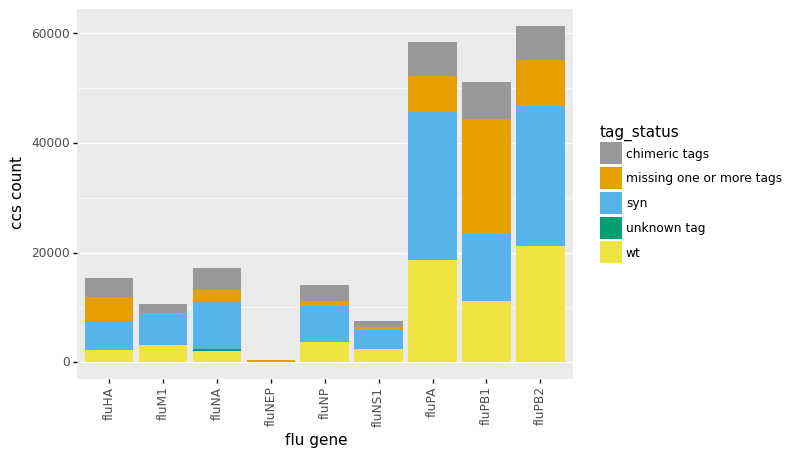

In [16]:
p = (
    p9.ggplot(tag_in_css_df,
              p9.aes('transcript', 'query_name', fill='tag_status'))
    + p9.geom_bar(stat='identity')
    + p9.theme(axis_text_x=p9.element_text(angle=90),
               panel_grid_major_x=p9.element_blank()
               )
    + p9.scale_fill_manual(values=CBPALETTE)
    + p9.xlab('flu gene')
    + p9.ylab('ccs count')
    + p9.theme(axis_text_x=p9.element_text(angle=90, hjust=0.5))

)
_ = p.draw()

p9.ggsave(plot=p, filename=plot_strand_exchange, verbose=False)

In [17]:
chimera_stats = (
    strand_exchange_df
    .assign(number=1)
    .groupby(['tag_status'])
    .agg({'tag_status': 'count'})
    .assign(fraction=lambda x: x.tag_status / x.tag_status.sum())
    )
chimera_stats

,tag_status,fraction
tag_status,,
chimeric tags,32425,0.137345
missing one or more tags,44362,0.187908
syn,94460,0.400112
unknown tag,523,0.002215
wt,64314,0.272420


Finaly we will add the `tag_status` to the alignment dataframe and save it

In [19]:
assert set(alignments['query_name']) == set(strand_exchange_df['query_name'])

merged_df = pd.merge(alignments,
                     strand_exchange_df[['query_name',
                                         'tag_status']],
                     how='left',
                     on=['query_name'],
                     validate='one_to_one')

merged_df.to_csv(mutation_and_tag_identity_df,
                 index=False, compression='gzip')